## Random Forest

In [25]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import os

# Load dataset
df = pd.read_csv('../../Data/df_heart_drop_imp.csv')

In [9]:
# Get the number of available CPU cores
num_cores = os.cpu_count()

print("Number of CPU cores available:", num_cores)

# Set number of cores
jobs = 5

Number of CPU cores available: 12


In [4]:
# Show 5 first rows
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,...,HeightInMeters,WeightInKilograms,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartDisease
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,No,...,1.70,80.74,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No,No
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,No,...,1.60,68.04,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,None of them,No,...,1.57,63.50,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,Yes,...,1.65,63.50,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.57,53.98,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No


In [5]:
# Data selection
    # From Hinn's code
target = 'HadHeartDisease'
features = df.drop(columns = [target])   
df = pd.get_dummies(df, columns=features.select_dtypes(include=['object']).columns)

# data split
df_train, df_test = train_test_split(df, 
                                    test_size = 0.25, 
                                    random_state = 69,
                                    stratify = df[target])

X_train = df_train.drop(columns = [target])
y_train = df_train[target]
X_test = df_test.drop(columns = [target])
y_test = df_test[target]

In [13]:
# Tuning Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'max_features': ['auto', 'sqrt', 'log2']
    # 'bootstrap': [True, False]
}

# max_features

In [14]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=jobs) # Parallel

# Perform GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model to make predictions on the testing data
best_rf_classifier = grid_search.best_estimator_
predictions = best_rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

/opt/anaconda3/envs/ucla/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/ucla/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
93 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ucla/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/e

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8888557051020125
Accuracy: 0.8890544716487776


In [27]:
predictions_proba = best_rf_classifier.predict_proba(X_test)
predictions_proba_positive_class = predictions_proba[:, 1]

roc_auc = roc_auc_score(y_test, predictions_proba_positive_class)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8356422034639205


In [24]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Generate the classification report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[96295   629]
 [11506   948]]
Classification Report:
              precision    recall  f1-score   support

          No       0.89      0.99      0.94     96924
         Yes       0.60      0.08      0.14     12454

    accuracy                           0.89    109378
   macro avg       0.75      0.53      0.54    109378
weighted avg       0.86      0.89      0.85    109378



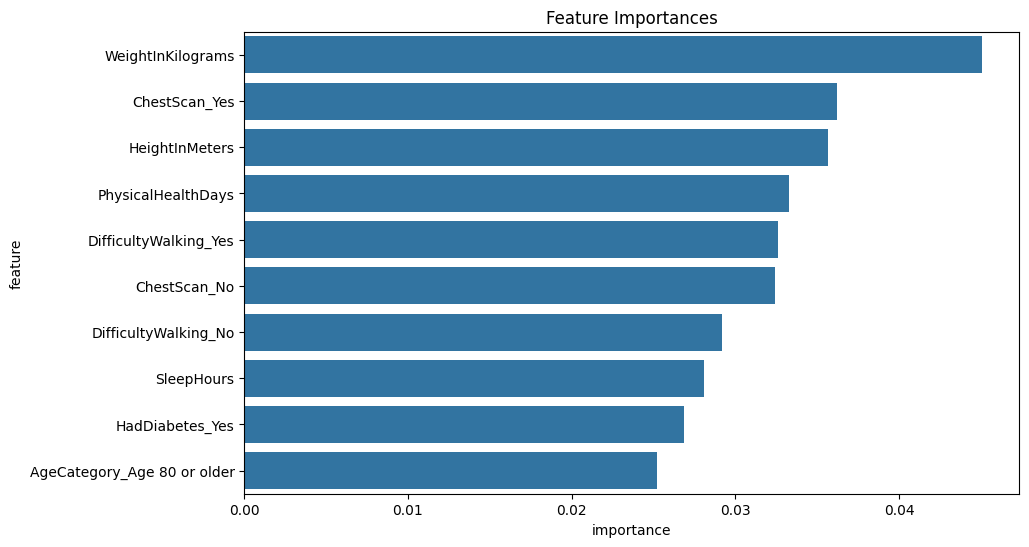

In [19]:
# Feature importance
feature_importances = best_rf_classifier.feature_importances_
feature_importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10))
plt.title('Feature Importances')
plt.show()

## XGBoost